### Imports

In [1]:
import importlib
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import modules.data_processing
from scipy.stats import ttest_ind, chi2_contingency, percentileofscore

In [1]:
## NLP imports

from textblob import TextBlob
import spacy
import string
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from wikitextparser import remove_markup, parse
from collections import defaultdict
from nltk import ngrams
from nltk.util import ngrams
import networkx as nx
from sklearn.feature_selection import chi2

In [3]:
importlib.reload(modules.data_processing)
from modules.data_processing import *

We start by defining a function that parses the data file and creates a pandas DataFrame containing the parsed data.

In [78]:
DATA_PATH = './data/wiki-RfA.txt'
EDITORS_PATH = './data/top_editors.txt'
AUTHORS_PATH = './data/top_authors.txt'
CREATORS_PATH = './data/top_creators.txt'
TALKS_DF = './data/talks_df.csv'

In [4]:
wiki_df = extract_data(DATA_PATH)
process_dataframe(wiki_df)

### Natural Language Processing

##### Sentiment analysis with Vader

Punctuation can provide valuable context for sentiment analysis as it can affect the emotional toned of a sentence. We will keep it then since Vader is designed to work with text including punctuation. It takes into account various linguistic and grammatical aspects to understand the sentiment expressed in a piece of text.

In [66]:
wiki_copy = wiki_df.copy()

In [67]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\liand\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [68]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

* Let's apply it on an example comment.

In [69]:
ex = wiki_copy.iloc[5]['CLE']
print(ex)
print('Scores = ', sia.polarity_scores(ex),end='\n')

Support There are plenty of important roles on this project, of which content creator is only one of them. BDD has done good work over a number of years. That his primary activity is not content creation is not of concern.
Scores =  {'neg': 0.04, 'neu': 0.769, 'pos': 0.191, 'compound': 0.7083}


VADER sentiment analysis provides sentiment scores for text: negative(neg), neutral(neu), positive(pos) and compound scores. 

The compound score takes values from -1 to 1, with values closer to -1 indicating negativity, 0 for neutrality and 1 for positivity. 

In [70]:
scores = {}
for i, row in wiki_copy.iterrows(): 
    scores[i] = sia.polarity_scores(row['CLE'])

In [71]:
scores_df = pd.DataFrame(scores).T

In [72]:
scores_df.head(10)

,neg,neu,pos,compound
0,0.000,0.426,0.574,0.4019
1,0.000,0.426,0.574,0.4019
2,0.000,0.426,0.574,0.4019
3,0.176,0.504,0.320,0.6124
4,0.000,0.612,0.388,0.9349
5,0.040,0.769,0.191,0.7083
6,0.000,0.722,0.278,0.4019
7,0.022,0.848,0.130,0.8850
8,0.058,0.665,0.278,0.9801
9,0.172,0.391,0.437,0.5267


In [73]:
# Merge the two dataframes
wiki_with_scores = pd.concat([wiki_copy, scores_df], axis = 1)
wiki_with_scores.sample(10)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE,neg,neu,pos,compound
105353,Finnrind,Samulili,1,1,2007,2007-09-28 12:26:00,"'''Support''' I know this user from Commons, a...",1665,"Support I know this user from Commons, and I'm...",0.000,0.753,0.247,0.8591
22870,Dank,Joe Decker,1,1,2010,2010-07-24 15:20:00,"Long time user, no problems, and your dedicati...",300,"Long time user, no problems, and your dedicati...",0.206,0.672,0.122,-0.2500
107355,VirtualSteve,ST47,1,1,2007,2007-07-18 07:09:00,'''Support''' - I think the editor is ready. --,1697,Support - I think the editor is ready.,0.000,0.435,0.565,0.6369
76875,Black Kite,Jamesontai,1,0,2008,2008-01-21 23:22:00,"Premature RfA, but '''Moral Support''' per Wiz...",1152,"Premature RfA, but Moral Support per Wizardman...",0.000,0.693,0.307,0.5499
147377,Xoloz,Sandstein,1,1,2006,2006-11-24 23:33:00,'''Support''' Excellent editor with firm grasp...,2467,Support Excellent editor with firm grasp of po...,0.000,0.484,0.516,0.7506
257,Tyrol5,Bilby,1,1,2013,2013-05-30 21:13:00,I've had a look through your editing history a...,2,I've had a look through your editing history a...,0.000,0.708,0.292,0.9836
89846,Wpktsfs,Ck lostsword,1,1,2007,2007-06-11 22:48:00,'''Support''' I don't see why not. Sufficient ...,1429,Support I don't see why not. Sufficient answer...,0.000,0.690,0.310,0.4019
182666,Exir Kamalabadi,Redux,1,1,2005,NaT,'''Support''' I think Redux will be a trustwor...,3288,Support I think Redux will be a trustworthy an...,0.000,0.678,0.322,0.8591
52191,NaN,Tango,-1,0,2009,NaT,,766,,0.000,0.000,0.000,0.0000
42806,Theleftorium,Steve,1,1,2009,2009-08-09 21:29:00,'''Support''' per Andy Walsh and SandyGeorgia....,582,Support per Andy Walsh and SandyGeorgia. Great...,0.000,0.491,0.509,0.8854


In [74]:
# Replace empty comments by NaN
# in order to remove them 
wiki_with_scores['CLE'].replace('', np.nan, inplace=True) 
wiki_with_scores['CLE'].isnull().sum()

9387

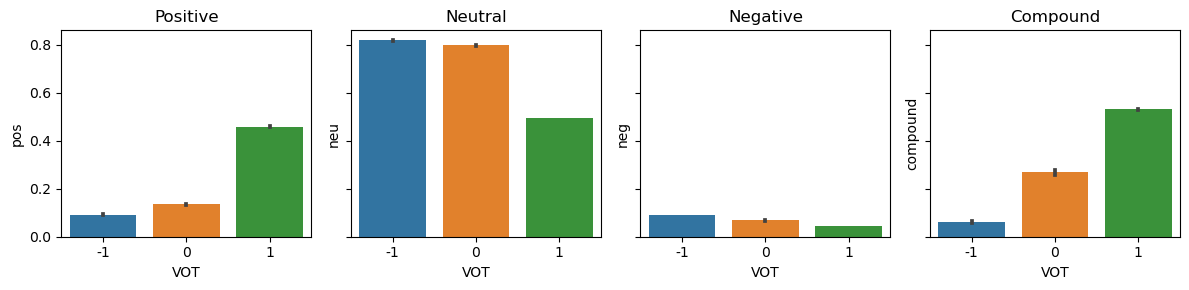

In [75]:
wiki_cle_dropna = wiki_with_scores.dropna(subset = 'CLE') # remove empty comments 
fig, axs = plt.subplots(1, 4, figsize=(12, 3),  sharey = True)
sns.barplot(data=wiki_cle_dropna, x='VOT', y='pos', ax=axs[0])
sns.barplot(data=wiki_cle_dropna, x='VOT', y='neu', ax=axs[1])
sns.barplot(data=wiki_cle_dropna, x='VOT', y='neg', ax=axs[2])
sns.barplot(data=wiki_cle_dropna, x='VOT', y='compound', ax=axs[3])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
axs[3].set_title('Compound')
plt.tight_layout()
plt.show()

Considering the Compound score that merges negative, neutral and positive scores, we can conclude that there is consistency on average between the votes and the associated comments.

In [76]:
compound_per_year = wiki_cle_dropna.groupby(['YEA', 'VOT'])['compound'].mean().reset_index()
compound_per_year.head(9)

,YEA,VOT,compound
0,2003,-1,-0.020150
1,2003,0,0.000000
2,2003,1,0.466455
3,2004,-1,0.076583
4,2004,0,0.192388
5,2004,1,0.399298
6,2005,-1,0.058232
7,2005,0,0.254654
8,2005,1,0.493900


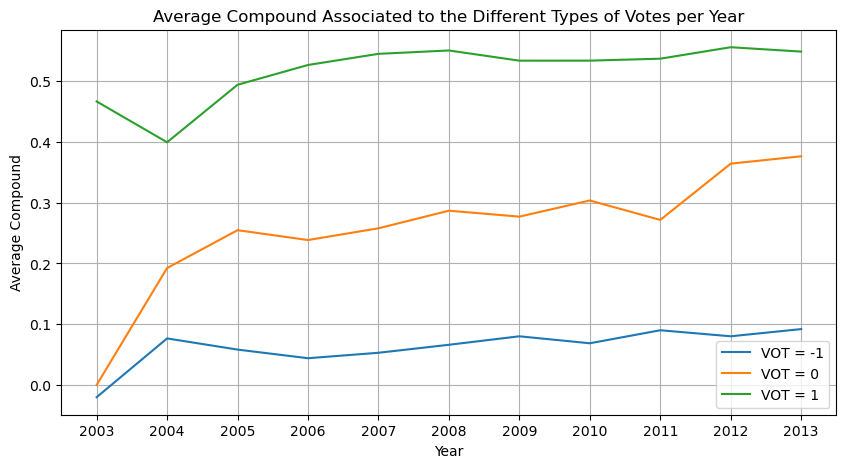

In [77]:
plt.figure(figsize=(10, 5))

for vot in [-1, 0, 1]: 
    sub_df = compound_per_year[compound_per_year['VOT'] == vot]
    plt.plot(sub_df['YEA'], sub_df['compound'], label = 'VOT = '+ str(vot))

plt.title('Average Compound Associated to the Different Types of Votes per Year')
plt.xticks(np.arange(2003, 2014))
plt.xlabel('Year')
plt.ylabel('Average Compound')
plt.grid()
plt.legend()

* For each year, the conclusion of consistency is still available. Therefore, generally, people tend to leave comments accordingly to their vote choice.

##### Sentiment analysis with TextBlob

In this section, we will use TextBlob, a powerful library for processing textual data, in order to extract the sentiment polarity and subjectivity of each comment.

**Notes:** 
* The *polarity* ranges from -1 (indicating negativity) to 1 (indicating positivity)
* The *subjectivity* ranges from 0 (reflecting objectivity) and 1 (reflecting subjectivity).

To achieve that, we have to do additional processing on the comments. 

In [78]:
wiki_copy['CLE'] = wiki_copy['CLE'].apply(nlp_pipeline) 
wiki_copy.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1,support as conom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1,support as nominator.
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1,support per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,support per noms. bdd is a strong contributor ...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,support with great pleasure. i work with bdd a...


In [79]:
# Remove the first word of each comment if contained on the list below
# to avoid a bias on the algorithm
wiki_copy['CLE'] = wiki_copy['CLE'].str.replace('^(support|oppose|neutral|strong support|weak support|happy support|unfortunate oppose) ', '', regex=True)
wiki_copy.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1,as conom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1,as nominator.
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1,per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,per noms. bdd is a strong contributor with tho...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,with great pleasure. i work with bdd at the wh...


In [80]:
# Show the first 10 comments completely
pd.set_option('display.max_colwidth', None)
print(wiki_copy['CLE'].head(10))
pd.reset_option('display.max_colwidth')

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  as conom.
1                                                                                                                                                                                                                                                                                                                                                                          

In [81]:
def polarity(text):  
    '''extracts the polarity of the text sentiment'''
    pol = TextBlob(text)
    return pol.sentiment.polarity

def subjectivity(text):
    '''extracts the subjectivity of the text sentiment'''
    pol = TextBlob(text)
    return pol.sentiment.subjectivity

In [82]:
# Add the polarity and the subjectivity to our dataframe
wiki_copy['polarity'] = wiki_copy['CLE'].apply(polarity)
wiki_copy['subjectivity'] = wiki_copy['CLE'].apply(subjectivity)
wiki_copy.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE,polarity,subjectivity
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1,as conom.,0.000000,0.000000
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1,as nominator.,0.000000,0.000000
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1,per noms.,0.000000,0.000000
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,per noms. bdd is a strong contributor with tho...,0.341667,0.491667
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,with great pleasure. i work with bdd at the wh...,0.638889,0.616667


When we look at the 3 first comments, they have 0 as polarity and 0 as subjectivity. The algorithm does not get any information from comments that are too short or meaningless. Therefore, we are going to show the distribution of the polarity for different levels of subjectivity.

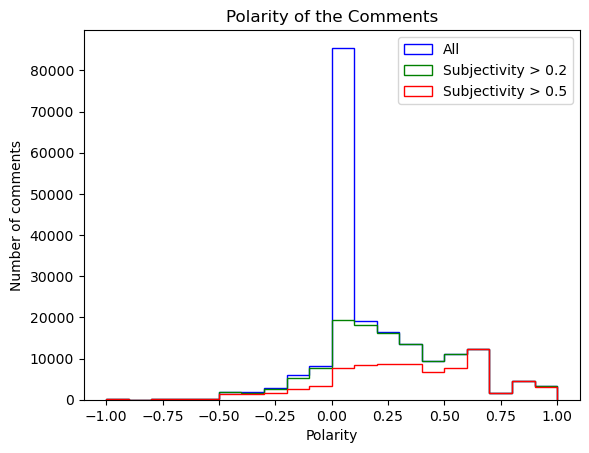

In [83]:
fig,ax = plt.subplots()
ax.hist(wiki_copy["polarity"],bins=20, histtype="step", label='All',color='b')
wiki_copy_subjectif = wiki_copy[wiki_copy['subjectivity'] > 0.2] 
ax.hist(wiki_copy_subjectif["polarity"],bins=20, histtype="step", label='Subjectivity > 0.2',color='g')
wiki_copy_subjectif = wiki_copy[wiki_copy['subjectivity'] > 0.5] 
ax.hist(wiki_copy_subjectif["polarity"],bins=20, histtype="step", label='Subjectivity > 0.5',color='r')
plt.xlabel('Polarity')
plt.ylabel('Number of comments')
plt.title('Polarity of the Comments')
plt.legend()
plt.show()

We observe that many comments show a polarity of 0 indicating a lack of subjectivity. We suppose that they are too brief to provide any interesting information. So to explore this further, we need to display the comments length for each level of subjectivity.

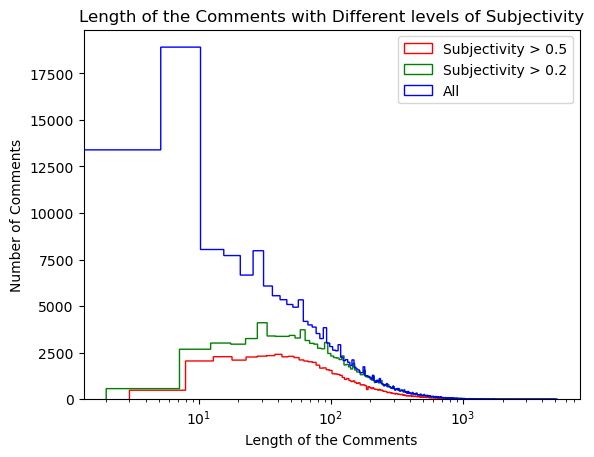

In [84]:
# Graph of the length of the comments for all the comments ( in blue) 
# and for the subjective comments (with subjectivity score more than 0.2 in green and 0.5 in red)
fig,ax = plt.subplots() 
ax.hist(wiki_copy[wiki_copy['subjectivity'] > 0.5]['CLE'].str.len(),bins=1000, histtype="step", label='Subjectivity > 0.5',color='r')
ax.hist(wiki_copy[wiki_copy['subjectivity'] > 0.2]['CLE'].str.len(),bins=1000, histtype="step", label='Subjectivity > 0.2',color='g')
ax.hist(wiki_copy['CLE'].str.len(),bins=1000, histtype="step", label='All',color='b')
plt.xlabel('Length of the Comments')
plt.ylabel('Number of Comments')
plt.title('Length of the Comments with Different levels of Subjectivity')
plt.xscale('log')
plt.legend()
plt.show()

Many comments appear too brief to provide substantial information. To ensure meaningful insights, we have established a subjectivity threshold of 0.2. Consequently, during our comment exploration, we exclusively utilize the subjective dataframe. Our objective is to enhance the quality of our results by keeping only those comments that are considered more interesting and informative.

In [85]:
# new dataframe with only subjective comments for the rest of our analysis
df_subjectiv = wiki_copy[wiki_copy['subjectivity'] > 0.2] 

###### Length of the comments

In this part, we explore the correlation between the length of the comment and the subjectivity.

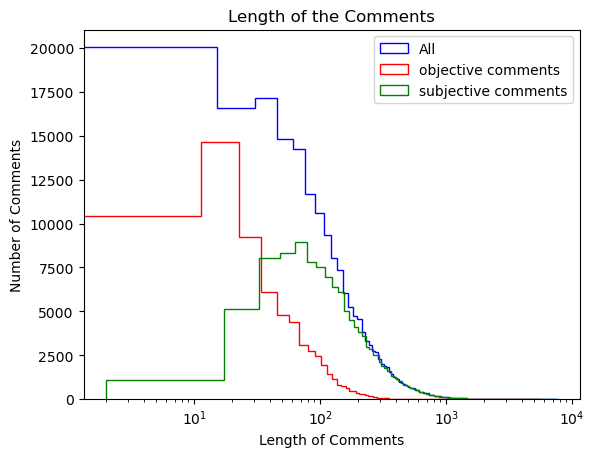

In [86]:
fig,ax = plt.subplots() 
ax.hist(wiki_copy['TXT'].str.len(),bins=500, histtype="step", label='All',color='b')
ax.hist(wiki_copy[wiki_copy['subjectivity'] < 0.2]['TXT'].str.len(),bins=500, histtype="step", label='objective comments',color='r')
ax.hist(wiki_copy[wiki_copy['subjectivity'] > 0.2]['TXT'].str.len(),bins=500, histtype="step", label='subjective comments',color='g')
plt.xlabel('Length of Comments')
plt.ylabel('Number of Comments')
plt.xscale('log')
plt.legend()
plt.title('Length of the Comments')
plt.show()

We note that typically, when a comment is excessively brief, it tends to be objective. Conversely, when a comment is more extensive in terms of characters, it is likely to be subjective.

##### Topic of the comments

In this part, we will use the latent dirichlet allocation in order to cluster the comments in various topics. The main idea is to extract some interesting keywords from the comments, so that we can understand what are the criteria to achieve a successful election.

We start with processing text with spacy.

In [87]:
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [88]:
def preprocess_text(text):
    ''' preprocesses text with lemmatization'''
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(tokens)

In [89]:
def process_stop_word(text, stem="None"):
    '''removes stop words'''
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']
    text_filtered = [word for word in text if not word in useless_words]
        # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string

In [90]:
# Clean the text for the LDA algorithm
df_subjectiv['preprocessed_txt'] = df_subjectiv['CLE'].apply(preprocess_text)
df_subjectiv['preprocessed_txt'] = df_subjectiv['preprocessed_txt'].apply(process_stop_word)

C:\Users\liand\AppData\Local\Temp\ipykernel_4312\2082174653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subjectiv['preprocessed_txt'] = df_subjectiv['CLE'].apply(preprocess_text)
C:\Users\liand\AppData\Local\Temp\ipykernel_4312\2082174653.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subjectiv['preprocessed_txt'] = df_subjectiv['preprocessed_txt'].apply(process_stop_word)


##### Transforming the preprocessed comments into a structured representation that captures the importance of terms within each comment using TF-IDF (Term Frequency-Inverse Document Frequency).

In [91]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
# Apply TF-IDF vectorization to the preprocessed text
dtm = vectorizer.fit_transform(df_subjectiv['preprocessed_txt'])

In [92]:
# LDA model
num_topics = 25 # Classify into n topics to visualize some positive or negative topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)  # Fit the LDA model to the TF-IDF matrix

LatentDirichletAllocation(n_components=25, random_state=42)

In [93]:
def print_top_words(model, vectorizer, n_words=10):
    '''prints the 10 words that are the best of each topics'''
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic #{topic_idx + 1}: {' | '.join(top_words)}")

In [94]:
print_top_words(lda, vectorizer)

Topic #1: ready | glad | attitude | hard | worthy | support | think | supportno | work | adminship
Topic #2: mop | deserve | support | extreme | good | bucket | hand | pleasure | editor | sincerely
Topic #3: positive | net | interaction | responsible | support | strongly | good | user | project | clue
Topic #4: answer | question | vandal | good | guy | fighter | nice | support | choice | great
Topic #5: nom | helpful | friendly | deal | big | good | support | supportgood | user | editor
Topic #6: meet | image | capable | admin | surprised | fair | support | criterion | standard | backlog
Topic #7: edit | low | count | mainspace | experience | space | namespace | month | talk | wikipedia
Topic #8: ok | sense | cheer | admin | common | new | dispute | support | good | think
Topic #9: weak | long | obviously | oppose | major | supporti | support | easy | concern | welcome
Topic #10: edit | summary | active | usage | use | page | good | support | rc | patrol
Topic #11: use | tool | trust |

We can now generate a topic number for all the comments in the dataframe:

In [95]:
# Add a column with the number of the topic for each comment
df_subjectiv.reset_index(drop=True, inplace=True)
df_subjectiv['Topic'] = df_subjectiv.index.map(lambda i: lda.transform(dtm[i]).argmax())
df_subjectiv.head()

C:\Users\liand\AppData\Local\Temp\ipykernel_4312\4101988350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subjectiv['Topic'] = df_subjectiv.index.map(lambda i: lda.transform(dtm[i]).argmax())


,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE,polarity,subjectivity,preprocessed_txt,Topic
0,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,per noms. bdd is a strong contributor with tho...,0.341667,0.491667,nom bdd strong contributor thousand edit year ...,9
1,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,with great pleasure. i work with bdd at the wh...,0.638889,0.616667,great pleasure work bdd coordinator see good w...,16
2,Sven Manguard,BDD,1,1,2013,2013-04-20 01:53:00,'''Support''' There are plenty of important ro...,1,there are plenty of important roles on this pr...,0.375000,0.775000,plenty important role project content creator ...,15
3,RockMagnetist,BDD,1,1,2013,2013-04-20 02:18:00,'''Support''' BDD already wields a broom pret...,1,bdd already wields a broom pretty well so why ...,0.095556,0.502963,bdd wield broom pretty formalize concerned lac...,6
4,Carrite,BDD,1,1,2013,2013-04-20 02:22:00,'''Support''' barring a completely unexpected ...,1,barring a completely unexpected answer to prof...,0.333214,0.529048,bar completely unexpected answer proforma ques...,15


We can visualize the polarity of each topics :

C:\Users\liand\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Polarity of Different Topics')

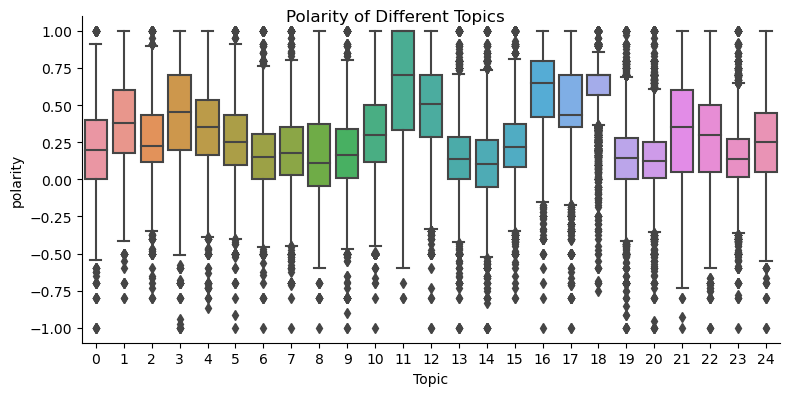

In [96]:
plot = sns.catplot(x='Topic', y='polarity', kind="box", data=df_subjectiv, errorbar='sd', height=4, aspect=2)
plot.fig.suptitle('Polarity of Different Topics')

By examining this plot, it becomes evident that topics 10-11-12 exhibit a higher polarity compared to the others. To delve deeper into the positive comments within this topic, we can inspect the list of prevalent words. Notable keywords include:
- positive
- interaction
- experienced
- helpful
- friendly

After reflection, we anticipate uncovering more insights by filtering comments exclusively for positive or negative sentiments.

##### Repeat the same with the positive/negative comments

In this part, we are gonna use only the subjective comments with a polarity greater than 0,5. The goal is to extract the topics and keywords to gives us an idea of the positive comments.

In [97]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
# Apply TF-IDF vectorization to the preprocessed text
dtm = vectorizer.fit_transform(df_subjectiv[df_subjectiv['polarity'] > 0.5]['preprocessed_txt'])

# LDA model
num_topics = 20 #separation in 20 topics to visualize some positive or negative topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)  # Fit the LDA model to the TF-IDF matrix

LatentDirichletAllocation(n_components=20, random_state=42)

In [98]:
print_top_words(lda, vectorizer)

Topic #1: good | page | judgement | talk | yes | supportgood | edit | work | support | user
Topic #2: tool | use | trust | good | mop | editor | user | admin | wisely | stuff
Topic #3: work | good | deserve | support | happy | lot | great | afd | editor | amazing
Topic #4: wikipedian | asset | thing | wikipedia | great | project | admin | good | wonderful | doubt
Topic #5: look | good | like | support | great | admin | supportall | encounter | productive | load
Topic #6: admin | great | good | vandal | fine | fighter | support | think | sure | editor
Topic #7: editor | good | great | job | support | track | record | person | concern | sensible
Topic #8: contribution | good | choice | interaction | supporti | support | summary | plenty | edit | great
Topic #9: edit | good | appear | addition | mainspace | vandalism | support | admin | great | mop
Topic #10: awesome | welcome | kind | support | say | admin | superb | brilliant | attitude | user
Topic #11: luck | user | good | problem | g

Some other interesting positive words :
- trustworthy
- contribution
- experience
- asset
- friendly
- work
- project 
- fighter 
- helpful 
- ...

These terms serve as valuable criterias to the acceptance of a person.

Then with the negative comments, with polarity smaller than -0,5.

In [99]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
# Apply TF-IDF vectorization to the preprocessed text
dtm = vectorizer.fit_transform(df_subjectiv[df_subjectiv['polarity'] < 0]['preprocessed_txt'])

# LDA model
num_topics = 20 #separation in 20 topics to visualize some positive or negative topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)  # Fit the LDA model to the TF-IDF matrix

LatentDirichletAllocation(n_components=20, random_state=42)

In [100]:
print_top_words(lda, vectorizer)

Topic #1: major | poor | concern | vandalism | block | careful | user | policy | answer | understanding
Topic #2: real | civility | oppose | bad | admin | support | feeling | user | candidate | reason
Topic #3: sorry | inexperienced | article | new | ridiculous | edit | account | oppose | contrib | support
Topic #4: seriously | sure | support | think | supporti | oh | admin | editor | stupid | wrong
Topic #5: bad | silly | crazy | support | oppose | close | afd | agree | admin | vote
Topic #6: oppose | page | signature | support | rfa | user | admin | username | edit | like
Topic #7: oppose | qualified | candidate | concern | support | section | response | user | questionable | random
Topic #8: fail | oppose | rfa | admin | help | need | user | support | pov | article
Topic #9: edit | low | experience | lack | mainspace | count | article | little | contribution | space
Topic #10: big | deal | positive | net | year | support | think | adminship | comfortable | weird
Topic #11: abuse | u

From this word list, we can infer certain criteria indicative of non-acceptance:
- uncivil
- stupid
- immature
- overdue 
- silly 
- inexperienced  


##### Which words are most frequently utilized in the comments?

In [101]:
all_text = ' '.join(df_subjectiv['preprocessed_txt'].astype(str))
all_text_p = ' '.join(df_subjectiv[df_subjectiv['polarity'] > 0.5]['preprocessed_txt'].astype(str))
all_text_n = ' '.join(df_subjectiv[df_subjectiv['polarity'] < -0.5]['preprocessed_txt'].astype(str))

# Tokenize the text into words
words = re.findall(r'\b\w+\b', all_text.lower())
words_p = re.findall(r'\b\w+\b', all_text_p.lower())
words_n = re.findall(r'\b\w+\b', all_text_n.lower())


# count occurrences of each word
word_counts = Counter(words)
word_counts_p = Counter(words_p)
word_counts_n = Counter(words_n)

# Print the most common words and their counts for all/positive/negative comments
print('Most common words in all the comments : \n', word_counts.most_common(20),'\n')
print('Most common words the positive comments : \n', word_counts_p.most_common(20),'\n')
print('Most common words the negative comments : \n', word_counts_n.most_common(20),'\n')

Most common words in all the comments : 
 [('good', 44827), ('support', 41769), ('admin', 35116), ('edit', 26420), ('user', 24785), ('oppose', 23884), ('editor', 22025), ('candidate', 18308), ('work', 18066), ('think', 17112), ('tool', 16240), ('experience', 16122), ('like', 15094), ('answer', 14354), ('time', 14308), ('article', 13735), ('need', 13342), ('rfa', 12845), ('great', 12413), ('question', 12133)] 

Most common words the positive comments : 
 [('good', 18123), ('support', 7265), ('great', 5935), ('admin', 5397), ('editor', 4859), ('user', 4234), ('excellent', 3784), ('candidate', 3092), ('work', 2935), ('look', 2746), ('answer', 2312), ('like', 2079), ('tool', 2068), ('luck', 1921), ('edit', 1703), ('question', 1576), ('contribution', 1566), ('see', 1560), ('think', 1475), ('experience', 1441)] 

Most common words the negative comments : 
 [('bad', 170), ('support', 122), ('oppose', 100), ('admin', 89), ('hate', 51), ('user', 47), ('think', 43), ('tool', 41), ('reason', 40),

##### Categorization with our categories

In this part we want to categorize the comments in some categories. For that we need some examples of words for each of them.

In [102]:
from empath import Empath

lexicon = Empath()

lexicon.create_category("hardskills", ["technical", "skills", "coding", "programming", "debugging", "edit", "administrator", "mediawiki", "templates", "bot", "scripting", "sandbox", "rollback", "protect", "user rights", "scripting", "API", "page deletion", "history merging","administrator role", "mediation", "policy enforcement", "template editing", "bot management", "advanced scripting", "technical expertise", "code review", "user permissions", "database management"])
lexicon.create_category("softskills", ["communication skills", "leadership qualities", "empathetic approach", "conflict resolution skills", "adaptive mindset", "collaborative spirit", "strong interpersonal skills","communication", "teamwork", "leadership", "empathy", "conflict resolution", "adaptability", "collaboration", "interpersonal"])
lexicon.create_category("friendship", ["friendly interactions", "supportive community", "trustworthy friendships", "loyal relationships", "conflict resolution among friends", "betrayal in social circles","friend", "friendly", "companionship", "supportive", "trustworthy", "loyal", "conflict", "betrayal"])
lexicon.create_category("experience", ["vast experience", "deep knowledge", "years of valuable experience", "strong contributor to the community", "thousands of edits made", "novice in the field", "inexperienced user", "lack of experience in certain areas", "inefficient practices","experience", "learned", "knowledge", "years of experience", "strong contributor", "thousands of edits", "novice", "inexperienced", "lack of experience", "inefficient"])
lexicon.create_category("negative_sentiment", ["dislike for certain actions", "disagreement with policies", "hatred towards specific users", "unpleasant interactions", "criticism of certain decisions", "strong opposition", "dislike", "disagree", "hate", "unpleasant", "criticism", "oppose"])


["skills", "learn", "techniques", "professionals", "fighting_skills", "methods", "abilities", "programming", "hone", "strategy", "strategies", "teamwork", "capabilities", "educate", "technique", "missions", "tactics", "method", "talents", "duplicate", "own_benefit", "implement", "potential", "master", "utilize", "potential", "strengths", "research", "weaknesses", "examples", "experts", "secret_weapon", "specialize", "technology", "tactic", "casting", "use", "survival_skills", "creators", "prototype", "basis", "discipline", "succeed", "basics", "program", "remake", "organization", "Therefore", "leadership", "eliminate", "operations", "improve", "special_abilities", "top_priority", "mind_control", "benefit", "invent", "works", "improvise", "self-defense", "experiments", "sponsors", "persuasion", "resource", "compromise", "mindset", "experiment", "establish", "evaluation", "research", "aspects", "development", "utilized", "work", "time_travel", "inventions", "special_ability", "telepathy"

In [103]:
def categorize_comment(comment):
    # Analyze the comment using the created categories
    categories = lexicon.analyze(comment, categories=["hardskills", "softskills", "friendship", "experience", "negative_sentiment"], normalize=True)
    
    # Get the category for the max of all of them
    theme = max(categories, key=categories.get)
    
    return theme

We implement a categorization system by creating a new 'Category' column for each comment. The assignment of a specific category is determined by analyzing the comment across predefined categories such as 'hardskills,' 'softskills,' 'friendship,' 'experience,' and 'negative_sentiment.' The chosen category for each comment is the one with the highest normalized score, providing a comprehensive way to classify comments based on their content and themes.

In [104]:
df_subjectiv['Category'] = df_subjectiv['CLE'].apply(categorize_comment)
df_subjectiv.head(10)

C:\Users\liand\AppData\Local\Temp\ipykernel_4312\2849244820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subjectiv['Category'] = df_subjectiv['CLE'].apply(categorize_comment)


,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE,polarity,subjectivity,preprocessed_txt,Topic,Category
0,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,per noms. bdd is a strong contributor with tho...,0.341667,0.491667,nom bdd strong contributor thousand edit year ...,9,hardskills
1,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,with great pleasure. i work with bdd at the wh...,0.638889,0.616667,great pleasure work bdd coordinator see good w...,16,hardskills
2,Sven Manguard,BDD,1,1,2013,2013-04-20 01:53:00,'''Support''' There are plenty of important ro...,1,there are plenty of important roles on this pr...,0.375000,0.775000,plenty important role project content creator ...,15,hardskills
3,RockMagnetist,BDD,1,1,2013,2013-04-20 02:18:00,'''Support''' BDD already wields a broom pret...,1,bdd already wields a broom pretty well so why ...,0.095556,0.502963,bdd wield broom pretty formalize concerned lac...,6,experience
4,Carrite,BDD,1,1,2013,2013-04-20 02:22:00,'''Support''' barring a completely unexpected ...,1,barring a completely unexpected answer to prof...,0.333214,0.529048,bar completely unexpected answer proforma ques...,15,friendship
5,Someguy1221,BDD,1,1,2013,2013-04-20 03:09:00,'''Support''' because I see no good reason not...,1,because i see no good reason not to.,-0.350000,0.600000,good reason,17,hardskills
6,Secret,BDD,1,1,2013,2013-04-20 03:18:00,'''Support''' if a qualified editor is asking ...,1,if a qualified editor is asking for the tools ...,0.102083,0.622917,qualified editor ask tool work area hardly adm...,10,hardskills
7,Dennis Brown,BDD,1,1,2013,2013-04-20 03:20:00,'''Support''' - I've done a formal review on h...,1,supporti've done a formal review on him previo...,0.310667,0.611111,formal review previously consider nominate sur...,5,hardskills
8,MJ94,BDD,1,1,2013,2013-04-20 03:25:00,'''Support''' From his hard work in copyeditin...,1,from his hard work in copyediting to his kind ...,0.154167,0.720833,hard work copyedit kind helpful personality fu...,4,friendship
9,King of Hearts,BDD,1,1,2013,2013-04-20 03:28:00,'''Support''' Seems to be a good editor. [[Use...,1,seems to be a good editor.,0.700000,0.600000,good editor,18,hardskills


In [105]:
category_column = 'Category'

# Create a CountVectorizer to convert text data into a bag-of-words representation
vectorizer_pos = CountVectorizer()
vectorizer_neg = CountVectorizer()

# Filter the DataFrame to include only comments with positive polarity
df_pos = df_subjectiv[df_subjectiv['polarity'] > 0.5]
# Filter the DataFrame to include only comments with negative polarity
df_neg = df_subjectiv[df_subjectiv['polarity'] <= 0.5]

# Fit and transform the preprocessed text data for positive polarity comments
X_pos = vectorizer_pos.fit_transform(df_pos['preprocessed_txt'])

# Fit and transform the preprocessed text data for negative polarity comments
X_neg = vectorizer_neg.fit_transform(df_neg['preprocessed_txt'])

# Calculate the chi-squared statistic for each term and category directly on the sparse matrix
chi2_stat_pos, p_val_pos = chi2(X_pos, df_pos[category_column])
chi2_stat_neg, p_val_neg = chi2(X_neg, df_neg[category_column])

# Create DataFrames with chi-squared statistics and corresponding terms
df_chi2_pos = pd.DataFrame({'Term': vectorizer_pos.get_feature_names_out(), 'Chi2': chi2_stat_pos, 'P-Value': p_val_pos})
df_chi2_neg = pd.DataFrame({'Term': vectorizer_neg.get_feature_names_out(), 'Chi2': chi2_stat_neg, 'P-Value': p_val_neg})

# Display the top terms for each category based on chi-squared statistics
top_terms_by_category_pos = {}
top_terms_by_category_neg = {}
threshold = 25  # Threshold

for category in df_subjectiv[category_column].unique():
    condition_pos = (df_pos[category_column] == category)
    top_terms_pos = df_chi2_pos.loc[(df_chi2_pos['Term'].isin(vectorizer_pos.get_feature_names_out()) & condition_pos) & (df_chi2_pos['Chi2'] > threshold)].nlargest(20, 'Chi2')['Term'].tolist()
    top_terms_by_category_pos[category] = top_terms_pos
    print(f"\nTop terms for '{category}' (positive polarity): {', '.join(top_terms_pos)}")

    condition_neg = (df_neg[category_column] == category)
    top_terms_neg = df_chi2_neg.loc[(df_chi2_neg['Term'].isin(vectorizer_neg.get_feature_names_out()) & condition_neg) & (df_chi2_neg['Chi2'] > threshold)].nlargest(20, 'Chi2')['Term'].tolist()
    top_terms_by_category_neg[category] = top_terms_neg
    print(f"\nTop terms for '{category}' (negative polarity): {', '.join(top_terms_neg)}")


Top terms for 'hardskills' (positive polarity): knowledge, ideal, opposition, honestly, wikipedia, section, especially, truly, luck, throught, process, term, ha, concept, killiondude, intelligence, attribute, gwen, adequate, acquire

Top terms for 'hardskills' (negative polarity): experience, conflict, participation, opposition, civil, willingness, opinion, understand, conduct, communication, sensible, vote, area, user, doubt, candidate, significant, think, weak, use

Top terms for 'experience' (positive polarity): bit, glory, necessity, agüeybaná, intellectual, redefine, supportemouse

Top terms for 'experience' (negative polarity): learn, ability, work, point, section, strong, merit, learning, encourage, delete, extent, editing, deal, evidence, level, resolution, vandalism, day, wise, task

Top terms for 'friendship' (positive polarity): kind, agree, neutral, indicate, bjweeks, downtoearth, editorwriter, foster, intentional, kumquat, neutralwikipediaspace, stricken, supportgiven, su

We observe that numerous words may not contribute positively to accurately representing the intended categories. To refine the categorization process, we introduce a threshold for comment acceptance within a category. If a comment lacks sufficient representation of a specific category, it is assigned to the 'other' category, ensuring a more discerning and meaningful classification of comments.

In [106]:
def categorize_comment(comment):
    categories = lexicon.analyze(comment, categories=["hardskills", "softskills", "friendship", "experience", "negative_sentiment"], normalize=True)
    
    # Determine the theme with the highest score
    theme = max(categories, key=categories.get)
    
    # Check if the theme's score is below a certain threshold to consider it not significant
    threshold = 0.1
    if categories[theme] < threshold:
        theme = "other"
    
    return theme


In [107]:
df_subjectiv['Category'] = df_subjectiv['CLE'].apply(categorize_comment)
df_subjectiv.head(10)

C:\Users\liand\AppData\Local\Temp\ipykernel_4312\2849244820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subjectiv['Category'] = df_subjectiv['CLE'].apply(categorize_comment)


,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE,polarity,subjectivity,preprocessed_txt,Topic,Category
0,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,per noms. bdd is a strong contributor with tho...,0.341667,0.491667,nom bdd strong contributor thousand edit year ...,9,other
1,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,with great pleasure. i work with bdd at the wh...,0.638889,0.616667,great pleasure work bdd coordinator see good w...,16,other
2,Sven Manguard,BDD,1,1,2013,2013-04-20 01:53:00,'''Support''' There are plenty of important ro...,1,there are plenty of important roles on this pr...,0.375000,0.775000,plenty important role project content creator ...,15,other
3,RockMagnetist,BDD,1,1,2013,2013-04-20 02:18:00,'''Support''' BDD already wields a broom pret...,1,bdd already wields a broom pretty well so why ...,0.095556,0.502963,bdd wield broom pretty formalize concerned lac...,6,other
4,Carrite,BDD,1,1,2013,2013-04-20 02:22:00,'''Support''' barring a completely unexpected ...,1,barring a completely unexpected answer to prof...,0.333214,0.529048,bar completely unexpected answer proforma ques...,15,other
5,Someguy1221,BDD,1,1,2013,2013-04-20 03:09:00,'''Support''' because I see no good reason not...,1,because i see no good reason not to.,-0.350000,0.600000,good reason,17,other
6,Secret,BDD,1,1,2013,2013-04-20 03:18:00,'''Support''' if a qualified editor is asking ...,1,if a qualified editor is asking for the tools ...,0.102083,0.622917,qualified editor ask tool work area hardly adm...,10,other
7,Dennis Brown,BDD,1,1,2013,2013-04-20 03:20:00,'''Support''' - I've done a formal review on h...,1,supporti've done a formal review on him previo...,0.310667,0.611111,formal review previously consider nominate sur...,5,other
8,MJ94,BDD,1,1,2013,2013-04-20 03:25:00,'''Support''' From his hard work in copyeditin...,1,from his hard work in copyediting to his kind ...,0.154167,0.720833,hard work copyedit kind helpful personality fu...,4,friendship
9,King of Hearts,BDD,1,1,2013,2013-04-20 03:28:00,'''Support''' Seems to be a good editor. [[Use...,1,seems to be a good editor.,0.700000,0.600000,good editor,18,other


In [138]:
# Print the number of comments for each theme
theme_counts = df_subjectiv['Category'].value_counts()
print(theme_counts)

Category
other                 121169
friendship              2814
negative_sentiment      2425
hardskills              1686
experience               997
softskills               334
Name: count, dtype: int64


While it's true that we lose a portion of comments by setting a threshold, it's important to note that the remaining comments assigned to a category tend to offer more meaningful representation. The decision to filter out comments below the threshold ensures that the included comments have a stronger association with the specified categories, contributing to a more accurate and focused categorization.

In [109]:
categories = ["hardskills", "softskills", "friendship", "experience", "negative_sentiment", "other"]

vectorizer = TfidfVectorizer(min_df=1, max_df=0.9, stop_words='english')

top_terms_by_category = {}

# Iterate through each category
for category in categories:
    # Filter comments for the current category
    condition = (df_subjectiv['Category'] == category)
    comments_category = df_subjectiv[condition]['preprocessed_txt'].tolist()
    
    # Apply TF-IDF vectorization
    X = vectorizer.fit_transform(comments_category)
    
    feature_names = vectorizer.get_feature_names_out()
    
    tfidf_scores = X.sum(axis=0).A1
    
    df_tfidf = pd.DataFrame({'Term': feature_names, 'TF-IDF': tfidf_scores})
    
    # Select top terms based on TF-IDF scores
    top_terms = df_tfidf.nlargest(20, 'TF-IDF')['Term'].tolist()
    
    top_terms_by_category[category] = top_terms
    
    # Print top terms for the current category
    print(f"\nTop terms for '{category}': {', '.join(top_terms)}")


Top terms for 'hardskills': work, good, use, support, tool, great, excellent, editor, user, admin, article, mop, potential, edit, wisely, benefit, candidate, lot, wikipedia, experience

Top terms for 'softskills': good, knowledge, support, contribution, policy, opposition, participation, great, conflict, excellent, editor, edit, involvement, communication, history, admin, user, wikipedia, strong, concern

Top terms for 'friendship': good, support, editor, trustworthy, user, trust, helpful, responsible, admin, friendly, contributor, luck, great, civil, candidate, tool, sensible, especially, excellent, kind

Top terms for 'experience': experience, need, good, support, user, oppose, admin, candidate, lack, editor, positive, ideal, edit, little, sorry, concern, great, knowledge, answer, area

Top terms for 'negative_sentiment': like, good, oppose, look, candidate, strong, support, admin, user, great, weak, editor, fine, agree, need, reason, excellent, answer, edit, experience

Top terms f

Now, our objective is to examine whether there are discernible differences in the choice of words between comments with positive and negative polarity (considering a threshold of +/- 0.5). This analysis aims to uncover distinctive language patterns associated with sentiments, providing insights into the vocabulary variations between positively and negatively polarized comments.

In [110]:
categories = ["hardskills", "softskills", "friendship", "experience", "negative_sentiment", "other"]

vectorizer = TfidfVectorizer(min_df=1, max_df=0.9, stop_words='english')

top_terms_by_category = {}

# Iterate through each category
for category in categories:
    # Filter comments for the current category and positive polarity
    condition_pos = (df_subjectiv['Category'] == category) & (df_subjectiv['polarity'] > 0.5)
    comments_category_pos = df_subjectiv[condition_pos]['preprocessed_txt'].tolist()
    
    X_pos = vectorizer.fit_transform(comments_category_pos)
    
    feature_names_pos = vectorizer.get_feature_names_out()
    
    tfidf_scores_pos = X_pos.sum(axis=0).A1
    
    df_tfidf_pos = pd.DataFrame({'Term': feature_names_pos, 'TF-IDF': tfidf_scores_pos})
    
    # Select top terms based on TF-IDF scores
    top_terms_pos = df_tfidf_pos.nlargest(10, 'TF-IDF')['Term'].tolist()
    
    top_terms_by_category[f'{category}_positive'] = top_terms_pos
    
    # Print top terms for the current category and positive polarity
    print(f"\nTop terms for '{category}' (positive polarity): {', '.join(top_terms_pos)}")
    
    # Filter comments for the current category and negative polarity
    condition_neg = (df_subjectiv['Category'] == category) & (df_subjectiv['polarity'] <= 0.5)
    comments_category_neg = df_subjectiv[condition_neg]['preprocessed_txt'].tolist()
    
    X_neg = vectorizer.fit_transform(comments_category_neg)
    
    feature_names_neg = vectorizer.get_feature_names_out()
    
    tfidf_scores_neg = X_neg.sum(axis=0).A1
    
    df_tfidf_neg = pd.DataFrame({'Term': feature_names_neg, 'TF-IDF': tfidf_scores_neg})
    
    # Select top terms based on TF-IDF scores
    top_terms_neg = df_tfidf_neg.nlargest(30, 'TF-IDF')['Term'].tolist()
    
    top_terms_by_category[f'{category}_negative'] = top_terms_neg
    
    # Print top terms for the current category and negative polarity
    print(f"\nTop terms for '{category}' (negative polarity): {', '.join(top_terms_neg)}")


Top terms for 'hardskills' (positive polarity): good, work, use, great, tool, support, excellent, editor, user, admin

Top terms for 'hardskills' (negative polarity): work, use, good, support, tool, admin, great, potential, edit, editor, user, article, summary, wikipedia, far, benefit, experience, need, definitely, hard, candidate, strong, skill, useful, mop, improve, like, learn, oppose, responsibly

Top terms for 'softskills' (positive polarity): good, contribution, support, great, knowledge, excellent, policy, history, participation, editor

Top terms for 'softskills' (negative polarity): knowledge, support, good, opposition, policy, conflict, contribution, participation, edit, oppose, concern, admin, user, strong, editor, conduct, involvement, need, experience, primarily, communication, wikipedia, resolve, potential, poor, excellent, raise, candidate, project, history

Top terms for 'friendship' (positive polarity): good, editor, support, user, trustworthy, trust, luck, great, adm

As for the votes categorized positive or negative...

In [111]:
categories = ["hardskills", "softskills", "friendship", "experience", "negative_sentiment", "other"]

vectorizer = TfidfVectorizer(min_df=1, max_df=0.9, stop_words='english')

top_terms_by_category = {}

# Iterate through each category
for category in categories:
    # Filter comments for the current category and positive polarity
    condition_pos = (df_subjectiv['Category'] == category) & (df_subjectiv['VOT'] == 1)
    comments_category_pos = df_subjectiv[condition_pos]['preprocessed_txt'].tolist()
    
    X_pos = vectorizer.fit_transform(comments_category_pos)
    
    feature_names_pos = vectorizer.get_feature_names_out()
    
    tfidf_scores_pos = X_pos.sum(axis=0).A1
    
    df_tfidf_pos = pd.DataFrame({'Term': feature_names_pos, 'TF-IDF': tfidf_scores_pos})
    
    # Select top terms based on TF-IDF scores
    top_terms_pos = df_tfidf_pos.nlargest(10, 'TF-IDF')['Term'].tolist()
    
    top_terms_by_category[f'{category}_positive'] = top_terms_pos
    
    # Print top terms for the current category and positive polarity
    print(f"\nTop terms for '{category}' (positive polarity): {', '.join(top_terms_pos)}")
    
    # Filter comments for the current category and negative polarity
    condition_neg = (df_subjectiv['Category'] == category) & (df_subjectiv['VOT'] == -1)
    comments_category_neg = df_subjectiv[condition_neg]['preprocessed_txt'].tolist()
    
    X_neg = vectorizer.fit_transform(comments_category_neg)
    
    feature_names_neg = vectorizer.get_feature_names_out()
    
    tfidf_scores_neg = X_neg.sum(axis=0).A1
    
    df_tfidf_neg = pd.DataFrame({'Term': feature_names_neg, 'TF-IDF': tfidf_scores_neg})
    
    # Select top terms based on TF-IDF scores
    top_terms_neg = df_tfidf_neg.nlargest(30, 'TF-IDF')['Term'].tolist()
    
    top_terms_by_category[f'{category}_negative'] = top_terms_neg
    
    # Print top terms for the current category and negative polarity
    print(f"\nTop terms for '{category}' (negative polarity): {', '.join(top_terms_neg)}")


Top terms for 'hardskills' (positive polarity): work, good, use, support, tool, great, excellent, editor, user, admin

Top terms for 'hardskills' (negative polarity): work, use, experience, oppose, edit, fair, summary, need, article, good, potential, user, content, low, admin, benefit, little, month, sorry, learn, weak, area, skill, bit, new, candidate, editor, concern, image, trust

Top terms for 'softskills' (positive polarity): good, knowledge, support, contribution, policy, great, opposition, excellent, participation, editor

Top terms for 'softskills' (negative polarity): oppose, knowledge, concern, participation, conduct, primarily, policy, admin, contribution, poor, communication, experience, lack, conflict, strong, low, potential, edit, user, support, involvement, issue, wikispace, opposition, little, candidate, wikipedia, sorry, raise, vote

Top terms for 'friendship' (positive polarity): good, support, editor, trustworthy, user, trust, helpful, responsible, admin, friendly



In the previous task, extracting valuable tips for aspiring Wikipedia administrators proved to be challenging. However, one noteworthy observation is the frequent appearance of the word "need." This word likely signifies the actions required to enhance one's administrator skills. To delve deeper, we aim to identify the words immediately following "need." Consequently, we will create bi-grams, as well as 3-4-5 grams, to extract groups of words that can provide insights for administrators and contribute to a better understanding of positive or negative votes.

##### n-grams

In [112]:
comments_category_neg = df_subjectiv['preprocessed_txt'].tolist()

# Create CountVectorizers for 2-gram to 5-gram
vectorizer_2gram = CountVectorizer(ngram_range=(2, 2), stop_words='english')
vectorizer_3gram = CountVectorizer(ngram_range=(3, 3), stop_words='english')
vectorizer_4gram = CountVectorizer(ngram_range=(4, 4), stop_words='english')
vectorizer_5gram = CountVectorizer(ngram_range=(5, 5), stop_words='english')

# Apply CountVectorizers to the comments
X_neg_2gram = vectorizer_2gram.fit_transform(comments_category_neg)
X_neg_3gram = vectorizer_3gram.fit_transform(comments_category_neg)
X_neg_4gram = vectorizer_4gram.fit_transform(comments_category_neg)
X_neg_5gram = vectorizer_5gram.fit_transform(comments_category_neg)

# Get feature names for each n-gram
feature_names_2gram = vectorizer_2gram.get_feature_names_out()
feature_names_3gram = vectorizer_3gram.get_feature_names_out()
feature_names_4gram = vectorizer_4gram.get_feature_names_out()
feature_names_5gram = vectorizer_5gram.get_feature_names_out()

# Find the indices of the n-grams starting with "need"
need_indices_2gram = [i for i, bigram in enumerate(feature_names_2gram) if bigram.startswith("need")]
need_indices_3gram = [i for i, trigram in enumerate(feature_names_3gram) if trigram.startswith("need")]
need_indices_4gram = [i for i, fourgram in enumerate(feature_names_4gram) if fourgram.startswith("need")]
need_indices_5gram = [i for i, fivegram in enumerate(feature_names_5gram) if fivegram.startswith("need")]

# Get the counts for each n-gram and create DataFrames
def get_ngram_occurrence_df(X_ngram, need_indices_ngram, feature_names_ngram, n):
    counts_ngram = X_ngram[:, need_indices_ngram].sum(axis=0).A1
    df_ngram_occurrence = pd.DataFrame({
        f'{n}-gram': feature_names_ngram[need_indices_ngram],
        'occurrence': counts_ngram
    })
    return df_ngram_occurrence.sort_values(by='occurrence', ascending=False)

# Create DataFrames for 2-gram to 5-gram
df_2gram_occurrence = get_ngram_occurrence_df(X_neg_2gram, need_indices_2gram, feature_names_2gram, 2)
df_3gram_occurrence = get_ngram_occurrence_df(X_neg_3gram, need_indices_3gram, feature_names_3gram, 3)
df_4gram_occurrence = get_ngram_occurrence_df(X_neg_4gram, need_indices_4gram, feature_names_4gram, 4)
df_5gram_occurrence = get_ngram_occurrence_df(X_neg_5gram, need_indices_5gram, feature_names_5gram, 5)

In [113]:
df_2gram_occurrence.head(20)

,2-gram,occurrence
42,need admin,1578
1882,need tool,1014
707,need experience,858
1874,need time,286
50,need administrator,221
1298,need people,200
839,need good,180
2072,need work,176
213,need bit,164
1083,need little,143


In [114]:
df_3gram_occurrence.head(20)

,3-gram,occurrence
721,need admin tool,245
536,need admin like,75
1367,need bit experience,60
3441,need good admin,47
767,need admin willing,45
5167,need people like,43
4533,need lot experience,43
769,need admin work,42
4418,need little experience,41
2844,need experience area,39


In [115]:
df_4gram_occurrence.head(20)

,4-gram,occurrence
9299,need use edit summary,23
1190,need admin tool good,13
8584,need tool good luck,11
7064,need remember adminship rfa,9
3638,need experience admin area,8
2156,need bit time experience,7
1413,need admin work image,7
3648,need experience admin related,7
3658,need experience adminrelate area,6
684,need admin good luck,6


In [116]:
df_5gram_occurrence.head(10)

,5-gram,occurrence
6648,need remember adminship rfa fail,8
884,need admin postive contributor good,6
8779,need use edit summary need,4
3479,need experience admin related area,4
1120,need admin tool fight vandalism,4
3638,need experience editing wikipedia space,4
8000,need tool edit summary usage,3
8079,need tool good reason oppose,3
523,need admin count vs delete,3
1540,need administrator spectrum positive interaction,3


*2-grams*
- need tool
- need experience
- need time
- need work

<br>

*3-grams*
- need admin tool
- need bit experience
- need lot experience
- need little time
- need vandal fighter

<br>

*4-grams*
- need use edit summary
- need experience admin area

<br>

*5-grams*
- need experience editing wikipedia space

Now, we aim to explore a similar analysis using the keyword 'lack.' This term can unveil valuable insights and tips, shedding light on areas where improvements or additional attention may be needed. Understanding what commonly follows the word 'lack' can provide us with constructive guidance, helping to identify key aspects for enhancement. Let's delve into the patterns associated with this term to glean actionable recommendations and refine our understanding further.

In [118]:
start_word = "lack"

# Filter comments for the current polarity
comments_category_neg = df_subjectiv['preprocessed_txt'].tolist()

# Create CountVectorizers for 2-gram to 5-gram
vectorizer_2gram = CountVectorizer(ngram_range=(2, 2), stop_words='english')
vectorizer_3gram = CountVectorizer(ngram_range=(3, 3), stop_words='english')
vectorizer_4gram = CountVectorizer(ngram_range=(4, 4), stop_words='english')
vectorizer_5gram = CountVectorizer(ngram_range=(5, 5), stop_words='english')

# Apply CountVectorizers to the comments
X_neg_2gram = vectorizer_2gram.fit_transform(comments_category_neg)
X_neg_3gram = vectorizer_3gram.fit_transform(comments_category_neg)
X_neg_4gram = vectorizer_4gram.fit_transform(comments_category_neg)
X_neg_5gram = vectorizer_5gram.fit_transform(comments_category_neg)

# Get feature names for each n-gram
feature_names_2gram = vectorizer_2gram.get_feature_names_out()
feature_names_3gram = vectorizer_3gram.get_feature_names_out()
feature_names_4gram = vectorizer_4gram.get_feature_names_out()
feature_names_5gram = vectorizer_5gram.get_feature_names_out()

# Find the indices of the n-grams starting with "need"
need_indices_2gram = [i for i, bigram in enumerate(feature_names_2gram) if bigram.startswith(start_word)]
need_indices_3gram = [i for i, trigram in enumerate(feature_names_3gram) if trigram.startswith(start_word)]
need_indices_4gram = [i for i, fourgram in enumerate(feature_names_4gram) if fourgram.startswith(start_word)]
need_indices_5gram = [i for i, fivegram in enumerate(feature_names_5gram) if fivegram.startswith(start_word)]

# Get the counts for each n-gram and create DataFrames
def get_ngram_occurrence_df(X_ngram, need_indices_ngram, feature_names_ngram, n):
    counts_ngram = X_ngram[:, need_indices_ngram].sum(axis=0).A1
    df_ngram_occurrence = pd.DataFrame({
        f'{n}-gram': feature_names_ngram[need_indices_ngram],
        'occurrence': counts_ngram
    })
    return df_ngram_occurrence.sort_values(by='occurrence', ascending=False)

# Create DataFrames for 2-gram to 5-gram
df_2gram_occurrence = get_ngram_occurrence_df(X_neg_2gram, need_indices_2gram, feature_names_2gram, 2)
df_3gram_occurrence = get_ngram_occurrence_df(X_neg_3gram, need_indices_3gram, feature_names_3gram, 3)
df_4gram_occurrence = get_ngram_occurrence_df(X_neg_4gram, need_indices_4gram, feature_names_4gram, 4)
df_5gram_occurrence = get_ngram_occurrence_df(X_neg_5gram, need_indices_5gram, feature_names_5gram, 5)

In [119]:
df_2gram_occurrence.head(20)

,2-gram,occurrence
306,lack experience,1101
264,lack edit,302
791,lack understanding,295
170,lack content,219
445,lack knowledge,180
55,lack article,179
577,lack policy,122
469,lack mainspace,104
477,lack maturity,103
434,lack judgement,66


In [120]:
df_3gram_occurrence.head(20)

,3-gram,occurrence
920,lack edit summary,164
2296,lack policy knowledge,98
609,lack content creation,77
1073,lack experience area,66
607,lack content contribution,57
1969,lack mainspace edit,50
2997,lack understanding policy,43
1049,lack experience admin,42
245,lack article write,38
244,lack article work,30


In [121]:
df_4gram_occurrence.head(20)

,4-gram,occurrence
1587,lack experience adminrelate area,23
1405,lack edit summary usage,22
1568,lack experience admin area,21
2018,lack experience major concern,21
4607,lack wikipedia namespace edit,17
2956,lack knowledge wikipedia policy,12
3580,lack project space edit,12
4613,lack wikipedia space edit,11
2339,lack experience wikipedia namespace,10
4058,lack talk page edit,10


In [122]:
df_5gram_occurrence.head(20)

,5-gram,occurrence
2107,lack experience low edit count,6
1627,lack experience admin related area,5
1625,lack experience admin relate area,5
2123,lack experience major concern try,5
4253,lack time prevent contribute time,4
893,lack content creation good contribution,4
1762,lack experience area want work,3
1477,lack edit wikipedia user talk,3
990,lack content writing bad sign,3
2433,lack experience wikipedia namespace edit,3


*2-grams*
- lack experience
- lack edit	
- lack understanding
- lack maturity
- lack judgment
- lack activity
- lack participation
- lack communication

<br>

*3-grams*
- lack edit summary
- lack policy knowledge
- lack content creation
- lack content contribution
- lack mainspace edit
- lack experience adminrelate
- lack article writing
- lack project space	

<br>

*4-grams*
- lack edit summary usage
- lack wikipedia namespace edit
- lack knowledge wikipedia policy
- lack project space edit

<br>

*5-grams*
- lack experience low edit count

Next, we extend our analysis to the term 'great,' aiming to uncover positive patterns and gain insights into what is deemed commendable. Exploring the words frequently associated with 'great' allows us to identify positive attributes and gather valuable information on what is considered praiseworthy. This exploration contributes to a comprehensive understanding of positive aspects and provides valuable insights for various contexts.

In [123]:
start_word = "great"

# Filter comments for the current polarity
comments_category_neg = df_subjectiv['preprocessed_txt'].tolist()

# Create CountVectorizers for 2-gram to 5-gram
vectorizer_2gram = CountVectorizer(ngram_range=(2, 2), stop_words='english')
vectorizer_3gram = CountVectorizer(ngram_range=(3, 3), stop_words='english')
vectorizer_4gram = CountVectorizer(ngram_range=(4, 4), stop_words='english')
vectorizer_5gram = CountVectorizer(ngram_range=(5, 5), stop_words='english')

# Apply CountVectorizers to the comments
X_neg_2gram = vectorizer_2gram.fit_transform(comments_category_neg)
X_neg_3gram = vectorizer_3gram.fit_transform(comments_category_neg)
X_neg_4gram = vectorizer_4gram.fit_transform(comments_category_neg)
X_neg_5gram = vectorizer_5gram.fit_transform(comments_category_neg)

# Get feature names for each n-gram
feature_names_2gram = vectorizer_2gram.get_feature_names_out()
feature_names_3gram = vectorizer_3gram.get_feature_names_out()
feature_names_4gram = vectorizer_4gram.get_feature_names_out()
feature_names_5gram = vectorizer_5gram.get_feature_names_out()

# Find the indices of the n-grams starting with "need"
need_indices_2gram = [i for i, bigram in enumerate(feature_names_2gram) if bigram.startswith(start_word)]
need_indices_3gram = [i for i, trigram in enumerate(feature_names_3gram) if trigram.startswith(start_word)]
need_indices_4gram = [i for i, fourgram in enumerate(feature_names_4gram) if fourgram.startswith(start_word)]
need_indices_5gram = [i for i, fivegram in enumerate(feature_names_5gram) if fivegram.startswith(start_word)]

# Get the counts for each n-gram and create DataFrames
def get_ngram_occurrence_df(X_ngram, need_indices_ngram, feature_names_ngram, n):
    counts_ngram = X_ngram[:, need_indices_ngram].sum(axis=0).A1
    df_ngram_occurrence = pd.DataFrame({
        f'{n}-gram': feature_names_ngram[need_indices_ngram],
        'occurrence': counts_ngram
    })
    return df_ngram_occurrence.sort_values(by='occurrence', ascending=False)

# Create DataFrames for 2-gram to 5-gram
df_2gram_occurrence = get_ngram_occurrence_df(X_neg_2gram, need_indices_2gram, feature_names_2gram, 2)
df_3gram_occurrence = get_ngram_occurrence_df(X_neg_3gram, need_indices_3gram, feature_names_3gram, 3)
df_4gram_occurrence = get_ngram_occurrence_df(X_neg_4gram, need_indices_4gram, feature_names_4gram, 4)
df_5gram_occurrence = get_ngram_occurrence_df(X_neg_5gram, need_indices_5gram, feature_names_5gram, 5)

In [124]:
df_2gram_occurrence.head(20)

,2-gram,occurrence
23,great admin,1629
371,great editor,1452
1065,great user,897
1129,great work,774
167,great candidate,548
266,great contributor,406
593,great job,300
70,great answer,287
302,great deal,283
263,great contribution,283


In [125]:
df_3gram_occurrence.head(20)

,3-gram,occurrence
564,great answer question,148
4866,great vandal fighter,131
2184,great editor great,78
2181,great editor good,73
179,great admin good,55
4670,great user great,50
4669,great user good,47
705,great asset project,43
721,great asset wikipedia,41
653,great article work,37


In [126]:
df_4gram_occurrence.head(20)

,4-gram,occurrence
233,great admin good luck,46
3201,great editor great admin,35
6151,great user great admin,22
3179,great editor good luck,16
3652,great editor unlikely abuse,15
3167,great editor good admin,14
37,great addition admin corps,11
2840,great edit summary usage,11
6496,great vandal fighter good,10
740,great answer question good,10


In [127]:
df_5gram_occurrence.head(10)

,5-gram,occurrence
3342,great editor unlikely abuse admin,13
662,great answer question good luck,5
5576,great user good answer question,4
5806,great user unlikely abuse tool,4
2883,great editor good answer question,4
5843,great userboxen rollback right article,4
5805,great user unlikely abuse admin,3
1206,great candidate disapprove strongarm tactic,3
2576,great edit summary usage great,3
271,great admin material good luck,3


*2-grams*
- great admin
- great editor
- great user
- great work
- greate contributor

<br>

*3-grams*
- great vandal fighter 
- great article writer

<br>

*4-grams*
- great edit summary usage
- great work fight vandalism

Continuing our exploration, we turn our attention to the term 'knowledge.' Examining the words commonly paired with 'knowledge' allows us to discern valuable insights and understand the aspects associated with a strong understanding of a subject. This analysis seeks to unveil patterns that illuminate what is often linked with possessing knowledge, providing us with a deeper comprehension of the context and significance of this attribute.

In [128]:
start_word = "knowledge"

# Filter comments for the current polarity
comments_category_neg = df_subjectiv['preprocessed_txt'].tolist()

# Create CountVectorizers for 2-gram to 5-gram
vectorizer_2gram = CountVectorizer(ngram_range=(2, 2), stop_words='english')
vectorizer_3gram = CountVectorizer(ngram_range=(3, 3), stop_words='english')
vectorizer_4gram = CountVectorizer(ngram_range=(4, 4), stop_words='english')
vectorizer_5gram = CountVectorizer(ngram_range=(5, 5), stop_words='english')

# Apply CountVectorizers to the comments
X_neg_2gram = vectorizer_2gram.fit_transform(comments_category_neg)
X_neg_3gram = vectorizer_3gram.fit_transform(comments_category_neg)
X_neg_4gram = vectorizer_4gram.fit_transform(comments_category_neg)
X_neg_5gram = vectorizer_5gram.fit_transform(comments_category_neg)

# Get feature names for each n-gram
feature_names_2gram = vectorizer_2gram.get_feature_names_out()
feature_names_3gram = vectorizer_3gram.get_feature_names_out()
feature_names_4gram = vectorizer_4gram.get_feature_names_out()
feature_names_5gram = vectorizer_5gram.get_feature_names_out()

# Find the indices of the n-grams starting with "need"
need_indices_2gram = [i for i, bigram in enumerate(feature_names_2gram) if bigram.startswith(start_word)]
need_indices_3gram = [i for i, trigram in enumerate(feature_names_3gram) if trigram.startswith(start_word)]
need_indices_4gram = [i for i, fourgram in enumerate(feature_names_4gram) if fourgram.startswith(start_word)]
need_indices_5gram = [i for i, fivegram in enumerate(feature_names_5gram) if fivegram.startswith(start_word)]

# Get the counts for each n-gram and create DataFrames
def get_ngram_occurrence_df(X_ngram, need_indices_ngram, feature_names_ngram, n):
    counts_ngram = X_ngram[:, need_indices_ngram].sum(axis=0).A1
    df_ngram_occurrence = pd.DataFrame({
        f'{n}-gram': feature_names_ngram[need_indices_ngram],
        'occurrence': counts_ngram
    })
    return df_ngram_occurrence.sort_values(by='occurrence', ascending=False)

# Create DataFrames for 2-gram to 5-gram
df_2gram_occurrence = get_ngram_occurrence_df(X_neg_2gram, need_indices_2gram, feature_names_2gram, 2)
df_3gram_occurrence = get_ngram_occurrence_df(X_neg_3gram, need_indices_3gram, feature_names_3gram, 3)
df_4gram_occurrence = get_ngram_occurrence_df(X_neg_4gram, need_indices_4gram, feature_names_4gram, 4)
df_5gram_occurrence = get_ngram_occurrence_df(X_neg_5gram, need_indices_5gram, feature_names_5gram, 5)

In [129]:
df_2gram_occurrence.head(20)

,2-gram,occurrence
469,knowledge policy,681
689,knowledge wikipedia,216
243,knowledge experience,74
805,knowledgeable editor,63
907,knowledgeable policy,58
18,knowledge admin,55
46,knowledge area,45
657,knowledge understanding,28
975,knowledgeable user,28
841,knowledgeable helpful,27


In [164]:
df_3gram_occurrence.head(20)

,3-gram,occurrence
1877,knowledge wikipedia policy,109
1242,knowledge policy guideline,66
1323,knowledge policy procedure,29
488,knowledge deletion policy,19
1953,knowledge wp policy,15
1238,knowledge policy good,14
1221,knowledge policy experience,13
2537,knowledgeable wikipedia policy,12
1880,knowledge wikipedia process,10
1232,knowledge policy fine,9


In [131]:
df_4gram_occurrence.head(20)

,4-gram,occurrence
2202,knowledge wikipedia policy guideline,22
2225,knowledge wikipedia policy procedure,5
2200,knowledge wikipedia policy good,4
2935,knowledgeable wikipedia policy guideline,4
2143,knowledge wikipedia core policy,3
1206,knowledge policy answer question,3
1364,knowledge policy fine administrator,3
2195,knowledge wikipedia policy experience,3
1438,knowledge policy guideline wikipedia,3
2346,knowledge wp policy guideline,3


In [132]:
df_5gram_occurrence.head(10)

,5-gram,occurrence
1308,knowledge policy good answer question,2
1047,knowledge open discussion controversial action,2
2796,knowledgeable wikipedia policy guideline exercise,2
2400,knowledgeable dedicated user genuinely willing,2
1486,knowledge policy procedure extremely rare,2
2091,knowledge wikipedia policy guideline answer,2
758,knowledge good answer relate question,2
1367,knowledge policy guideline willingness help,2
1729,knowledge research write allow add,2
2101,knowledge wikipedia policy guideline question,2


*2-grams*
- knowledge policy
- knowledge wikipedia
- knowledge editor
- knowledge deletion
- knowledge process

<br>

*3-grams*
- knowledge wikipedia policy
- knowledge policy guidline
- knowledge policy procedure
- knowledge deletion policy
- knowledge wikipedia process


Delving deeper into our analysis, we now redirect our attention to the term 'low.' Our exploration of words commonly associated with 'low' is geared towards unveiling patterns that signify diminished values or states. This inquiry seeks to shed light on areas that warrant consideration for improvement. By examining the context surrounding instances of 'low,' our objective is to attain a nuanced understanding of the factors influencing lower levels or values, thereby providing valuable insights for thoughtful assessment and enhancement.

In [133]:
start_word = "low"

# Filter comments for the current polarity
comments_category_neg = df_subjectiv['preprocessed_txt'].tolist()

# Create CountVectorizers for 2-gram to 5-gram
vectorizer_2gram = CountVectorizer(ngram_range=(2, 2), stop_words='english')
vectorizer_3gram = CountVectorizer(ngram_range=(3, 3), stop_words='english')
vectorizer_4gram = CountVectorizer(ngram_range=(4, 4), stop_words='english')
vectorizer_5gram = CountVectorizer(ngram_range=(5, 5), stop_words='english')

# Apply CountVectorizers to the comments
X_neg_2gram = vectorizer_2gram.fit_transform(comments_category_neg)
X_neg_3gram = vectorizer_3gram.fit_transform(comments_category_neg)
X_neg_4gram = vectorizer_4gram.fit_transform(comments_category_neg)
X_neg_5gram = vectorizer_5gram.fit_transform(comments_category_neg)

# Get feature names for each n-gram
feature_names_2gram = vectorizer_2gram.get_feature_names_out()
feature_names_3gram = vectorizer_3gram.get_feature_names_out()
feature_names_4gram = vectorizer_4gram.get_feature_names_out()
feature_names_5gram = vectorizer_5gram.get_feature_names_out()

# Find the indices of the n-grams starting with "need"
need_indices_2gram = [i for i, bigram in enumerate(feature_names_2gram) if bigram.startswith(start_word)]
need_indices_3gram = [i for i, trigram in enumerate(feature_names_3gram) if trigram.startswith(start_word)]
need_indices_4gram = [i for i, fourgram in enumerate(feature_names_4gram) if fourgram.startswith(start_word)]
need_indices_5gram = [i for i, fivegram in enumerate(feature_names_5gram) if fivegram.startswith(start_word)]

# Get the counts for each n-gram and create DataFrames
def get_ngram_occurrence_df(X_ngram, need_indices_ngram, feature_names_ngram, n):
    counts_ngram = X_ngram[:, need_indices_ngram].sum(axis=0).A1
    df_ngram_occurrence = pd.DataFrame({
        f'{n}-gram': feature_names_ngram[need_indices_ngram],
        'occurrence': counts_ngram
    })
    return df_ngram_occurrence.sort_values(by='occurrence', ascending=False)

# Create DataFrames for 2-gram to 5-gram
df_2gram_occurrence = get_ngram_occurrence_df(X_neg_2gram, need_indices_2gram, feature_names_2gram, 2)
df_3gram_occurrence = get_ngram_occurrence_df(X_neg_3gram, need_indices_3gram, feature_names_3gram, 3)
df_4gram_occurrence = get_ngram_occurrence_df(X_neg_4gram, need_indices_4gram, feature_names_4gram, 4)
df_5gram_occurrence = get_ngram_occurrence_df(X_neg_5gram, need_indices_5gram, feature_names_5gram, 5)

In [134]:
df_2gram_occurrence.head(20)

,2-gram,occurrence
131,low edit,534
289,low number,165
241,low level,124
253,low mainspace,78
6,low activity,70
417,low talk,48
466,low wikipedia,42
445,low use,42
159,low experience,41
9,low admin,30


In [135]:
df_3gram_occurrence.head(20)

,3-gram,occurrence
355,low edit count,346
394,low edit summary,104
816,low number edit,59
732,low mainspace edit,45
1219,low use edit,30
632,low level activity,20
668,low level wikipedianamespace,20
1278,low wikipedia space,16
823,low number mainspace,16
667,low level wikipedia,16


In [136]:
df_4gram_occurrence.head(20)

,4-gram,occurrence
641,low edit summary usage,67
1668,low use edit summary,30
967,low level wikipedianamespace edit,19
965,low level wikipedia namespace,16
1226,low number mainspace edit,15
1050,low mainspace edit count,15
1663,low usage edit summary,14
1378,low project space edit,12
561,low edit count wikipedia,11
1742,low wikipedia space edit,10


In [137]:
df_5gram_occurrence.head(10)

,5-gram,occurrence
1064,low level wikipedianamespace edit indicate,17
1063,low level wikipedia namespace edit,16
705,low edit summary usage concern,7
423,low edit count edit summary,7
616,low edit count wikipedia namespace,7
1374,low number wikispace edit suggest,4
1808,low use edit summary major,4
726,low edit summary usage major,4
724,low edit summary usage low,4
1257,low number article talk edit,4


*2-grams*
- low edit
- low activity
- low experience

<br>

*3-grams*
- low edit count
- low edit summary
- low mainspace edit
- low project space
- low usage edit

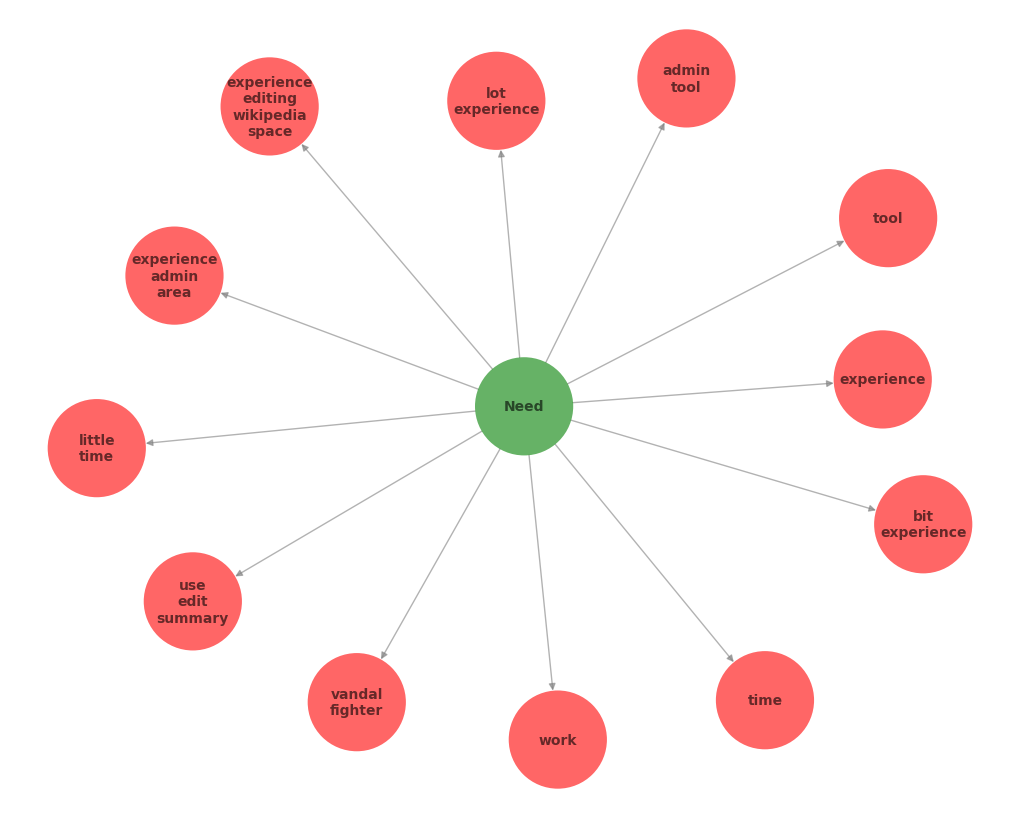

In [245]:
text_data = [
    "Need tool",
    "Need experience",
    "Need time",
    "Need work",
    "Need admin tool",
    "Need bit experience",
    "Need lot experience",
    "Need little time",
    "Need vandal fighter",
    "Need use edit summary",
    "Need experience admin area",
    "Need experience editing wikipedia space"
]

G = nx.DiGraph()

# Add "Need" and center
G.add_node("Need", size=3000, color='blue', font_size=20, font_color='black', font_weight='bold')

# Add other nodes and link with "Need"
for expression in text_data:
    words = expression.split()
    node_label = '\n'.join(words[1:])
    G.add_node(node_label)
    G.add_edge("Need", node_label)

pos = nx.spring_layout(G)

node_sizes = [100 if node == 'Need' else 30 for node in G.nodes]

node_colors = ['green' if node == 'Need' else 'red' for node in G.nodes]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, font_color='black', font_weight='bold',
        node_size=5000, node_color=node_colors, edge_color='gray', linewidths=0, alpha=0.6)
#plt.savefig("need.png", format="png")
plt.show()

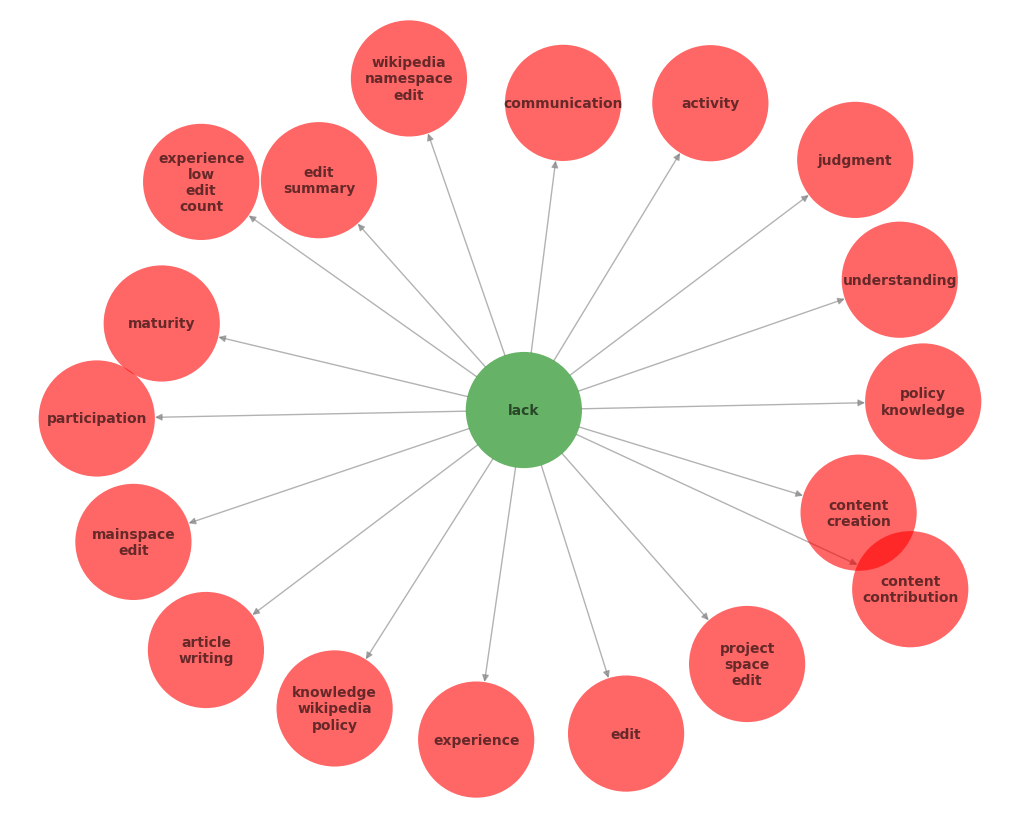

In [256]:
text_data = [
    "lack experience",
    "lack edit",
    "lack understanding",
    "lack maturity",
    "lack judgment",
    "lack activity",
    "lack participation",
    "lack communication",
    "lack edit summary",
    "lack policy knowledge",
    "lack content creation",
    "lack content contribution",
    "lack mainspace edit",
    "lack article writing",
    "lack wikipedia namespace edit",
    "lack knowledge wikipedia policy",
    "lack project space edit",
    "lack experience low edit count"
]

G = nx.DiGraph()

# Add "lack" and center
G.add_node("lack", size=3000, color='blue', font_size=20, font_color='black', font_weight='bold')

# Add other nodes and link with "Need"
for expression in text_data:
    words = expression.split()
    node_label = '\n'.join(words[1:])
    G.add_node(node_label)
    G.add_edge("lack", node_label)

pos = nx.spring_layout(G)

node_sizes = [100 if node == 'lack' else 30 for node in G.nodes]

node_colors = ['green' if node == 'lack' else 'red' for node in G.nodes]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, font_color='black', font_weight='bold',
        node_size=7000, node_color=node_colors, edge_color='gray', linewidths=0, alpha=0.6)
#plt.savefig("lack.png", format="png")
plt.show()

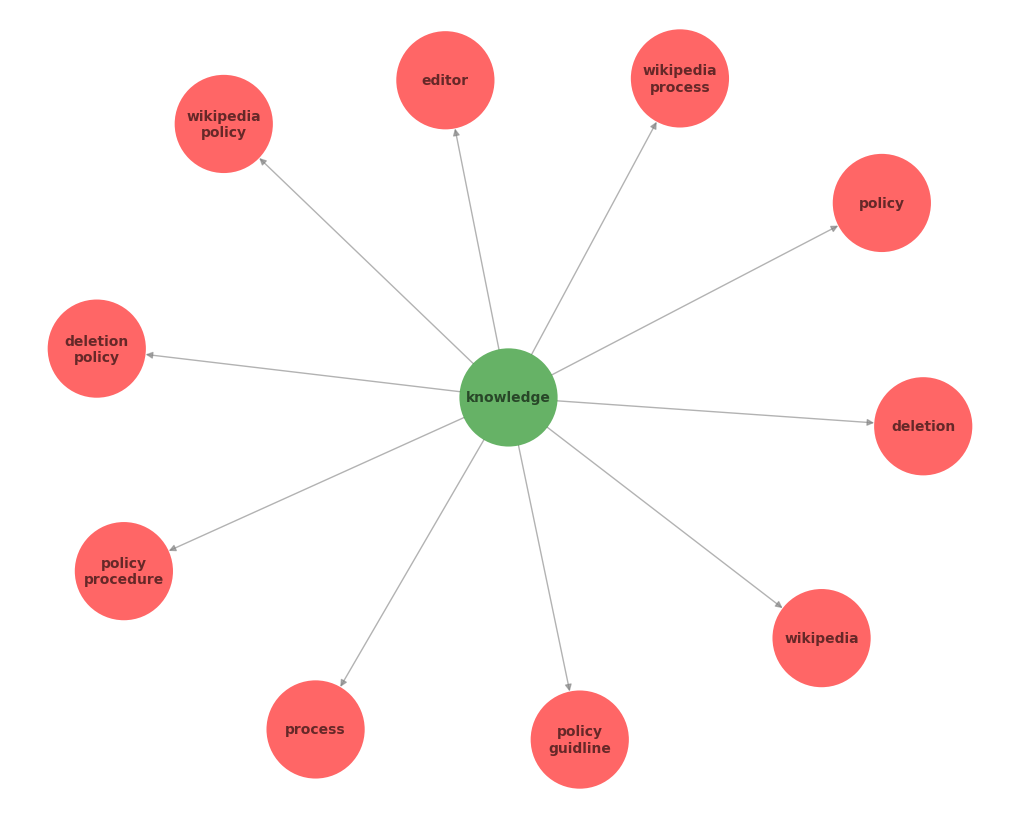

In [255]:
text_data = [
    "knowledge policy",
    "knowledge wikipedia",
    "knowledge editor",
    "knowledge deletion",
    "knowledge process",
    "knowledge wikipedia policy",
    "knowledge policy guidline",
    "knowledge policy procedure",
    "knowledge deletion policy",
    "knowledge wikipedia process"
]

G = nx.DiGraph()

# Add "knowledge" and center
G.add_node("knowledge", size=3000, color='blue', font_size=20, font_color='black', font_weight='bold')

# Add other nodes and link with "knowledge"
for expression in text_data:
    words = expression.split()
    node_label = '\n'.join(words[1:])
    G.add_node(node_label)
    G.add_edge("knowledge", node_label)

pos = nx.spring_layout(G)

node_sizes = [100 if node == 'knowledge' else 30 for node in G.nodes]

node_colors = ['green' if node == 'knowledge' else 'red' for node in G.nodes]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, font_color='black', font_weight='bold',
        node_size=5000, node_color=node_colors, edge_color='gray', linewidths=0, alpha=0.6)
#plt.savefig("knowledge.png", format="png")
plt.show()

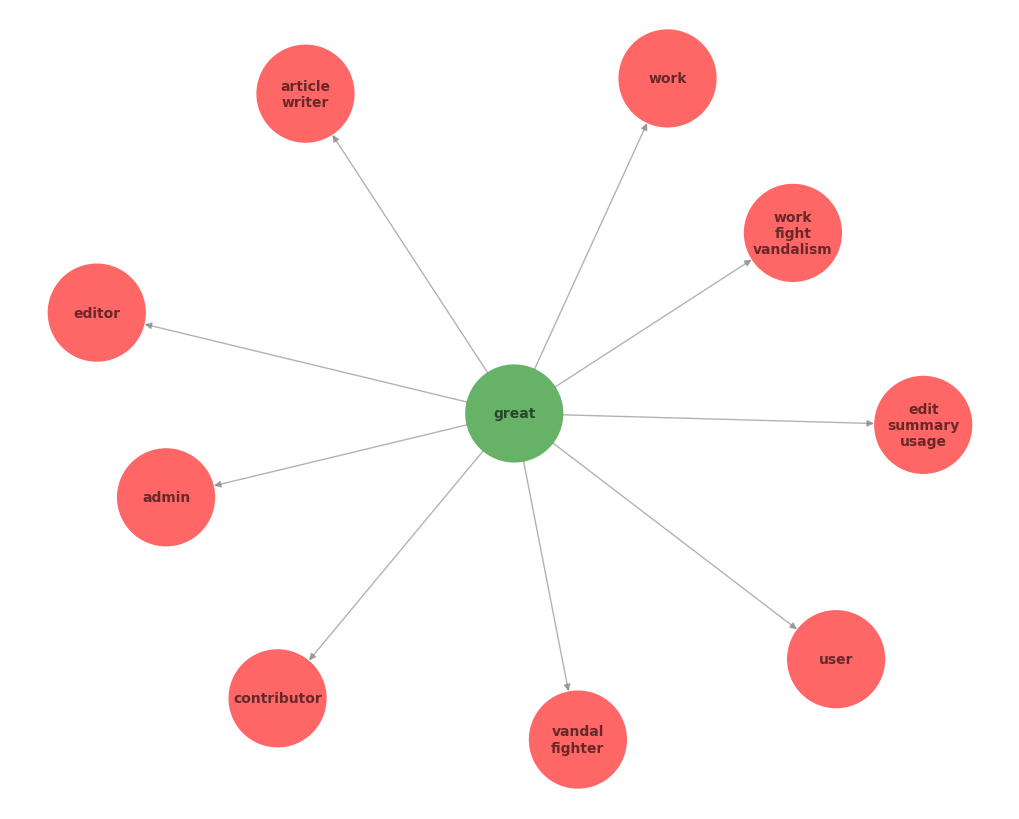

In [248]:
text_data = [
    "great admin",
    "great editor",
    "great user",
    "great work",
    "great contributor",
    "great vandal fighter",
    "great article writer",
    "great edit summary usage",
    "great work fight vandalism"
]


G = nx.DiGraph()

# Add "great" and center
G.add_node("great", size=3000, color='blue', font_size=20, font_color='black', font_weight='bold')

# Add other nodes and link with "great"
for expression in text_data:
    words = expression.split()
    node_label = '\n'.join(words[1:])
    G.add_node(node_label)
    G.add_edge("great", node_label)

pos = nx.spring_layout(G)

node_sizes = [100 if node == 'great' else 30 for node in G.nodes]

node_colors = ['green' if node == 'great' else 'red' for node in G.nodes]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, font_color='black', font_weight='bold',
        node_size=5000, node_color=node_colors, edge_color='gray', linewidths=0, alpha=0.6)
#plt.savefig("great.png", format="png")
plt.show()

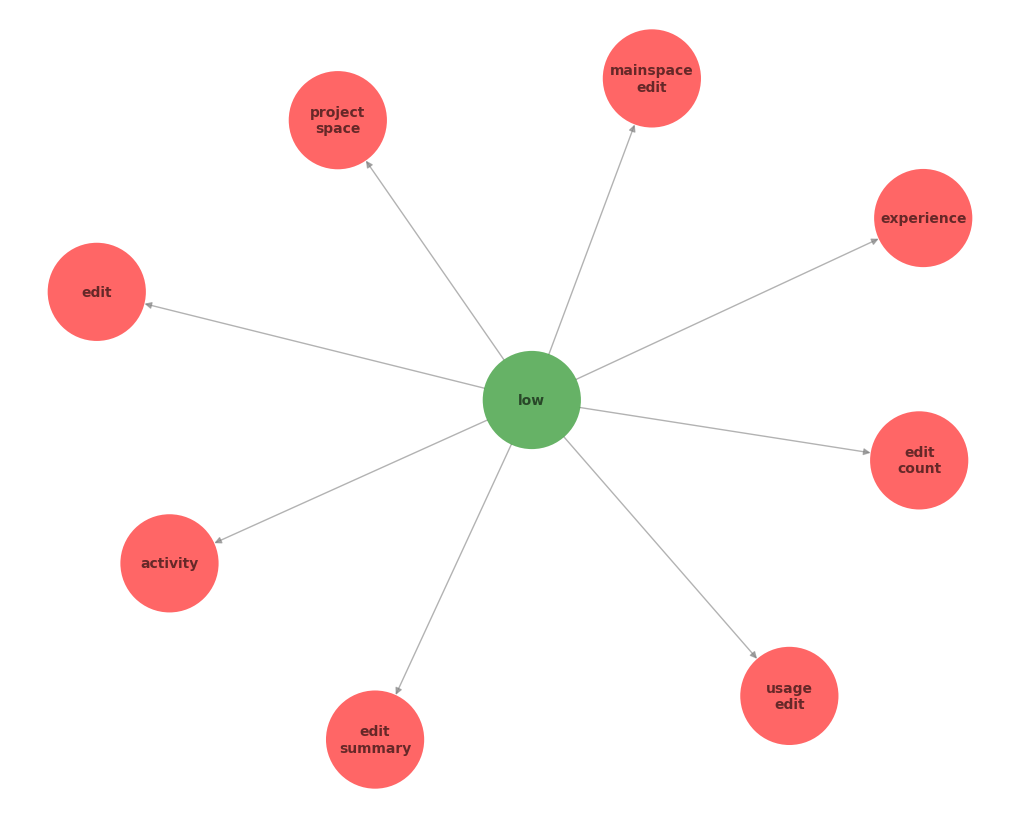

In [249]:
text_data = [
    "low edit",
    "low activity",
    "low experience",
    "low edit count",
    "low edit summary",
    "low mainspace edit",
    "low project space",
    "low usage edit"
]


G = nx.DiGraph()

# Add "great" and center
G.add_node("low", size=3000, color='blue', font_size=20, font_color='black', font_weight='bold')

# Add other nodes and link with "great"
for expression in text_data:
    words = expression.split()
    node_label = '\n'.join(words[1:])
    G.add_node(node_label)
    G.add_edge("low", node_label)

pos = nx.spring_layout(G)

node_sizes = [100 if node == 'low' else 30 for node in G.nodes]

node_colors = ['green' if node == 'low' else 'red' for node in G.nodes]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, font_color='black', font_weight='bold',
        node_size=5000, node_color=node_colors, edge_color='gray', linewidths=0, alpha=0.6)
#plt.savefig("low.png", format="png")
plt.show()